2022-09-15

1. EC를 추가

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

2. 두가지 경우 비교

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + sigmoid* w *(x**5)

2022-09-20

loss =

[f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}
 + f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

 [f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}]**2
 + [f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

2022-09-29

Work 1

1 : ODE 4차 오차 감소율 없을때 출력

2 : ODE 5차 오차 감소율 없을때 출력

3 : ODE 4차 + EC Case1 w 계수들 exact 계수들과 일치하는 경우에 대해서 비교

2022-10-10

Exam 1

exp(-x)

Error, exact(4차, 5차), train(4차, 5차, 4차+EC Case1, Case2)

2022-10-12

EC 각 데이터별 학습

내적 부분 변경

데이터에 따라서 다른 값.

2022-10-16

NN + NN*x**2

2022-10-23

1_NN + 1_NN

2_NN + 1_NN

3_NN + 1_NN

2022-10-24

코드 전체 다시 훑어 보기, 수정

tensorflow2 함정

range -> tf.range 사용하면 속도 빨라짐

tensor로 계산되다 numpy 사용시 gradient 추척 못 할 수 있음

tf.watch(변수)로 추적 해야 할 수 있음
```
ex)
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(input_)
    logits_seven = model(input_)[:, 7]
grad_for_inp = tape.gradient(logits_seven, input_)

print(grad_for_inp)
```

여러 손실을 총 손실에 추가하는 경우 추적을 못 할 수 있음


2022-10-26

1 + NN(x)*x 

1 + w*x

차이

---

loss_function2

y'(x) = f(x, y)

y(x) = p2(x) + z(x)

z(x) = y(x) - p2(x) ~~ NN(x)*x := p2^

z'(x) = f(x, y) - P2'(x) ~~ NN(x) + d_NN(x)*x

Loss Function

f(x, p2(x) + NN(x)*x) - p2'(x) - (NN(x) + d_NN(x)*x)

2022-10-27

코드 정리

loss_function 다양한 종류로 실행

2022-10-28

loss Function2 

f(x, p2(x) + NN(x)*x) - p2'(x) - (NN(x) + d_NN(x)*x)

결과 좋음

loss가 더 적은 결과가 exp와 더 멀어짐.

loss 0.8664 일때 exp와 비슷함.

근사값을 통해 loss를 구하기에 생기는 일 같다는 생각이 듦.

오히려 loss가 0이 될수록 우리가 원하는 결과 값이랑 다를 수 있음.

오히려 로컬 미니멈에 빠져야 원하는 결과를 얻을 수 있음.

과적합이 문제가 됨

random seed 값 알아 놓기

ODE_tensor -> data by W train

2022-10-31

data by data W 문제점

y' = f(x, y)를 비슷하게 만족하는 y의 W값이 너무 많음

---

square, sqrt의 경우 0 or 음수 값이 들어가면 nan으로 값 오류가 생길 수 있음

abs를 통해 절대값을 취해줘도 되지 않나.

2022-11-08

w, w trace, loss, loss trace, Learning Rate, delta, n 등 텍스트 화해서 저장

EC 추가 될때 W 저장을 어떻게 할지

2022-11-10

case별로 구분

In [127]:
'''
    모든 주석은 읽고 필요 없는 부분은 지우셔도 됩니다.
'''

'\n    모든 주석은 읽고 필요 없는 부분은 지우셔도 됩니다.\n'

Module import

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow import transpose
from tensorflow.math import sigmoid
from tensorflow.experimental.numpy import dot
from openpyxl import Workbook
import sympy as sp

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [3]:
def psy_analytic(x, lamb = 1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def A(x, case = 1):
    if case == 1:
        return -1

def B(x, case = 1):
    if case == 1:
        return 0

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, n = 4, case = 1): 
    '''
        y(x) = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    for i in range(1, n+1):
        y += w[i-1]*x**i
    
    return y

def yprime(x, w, n=4, bias = 0.):
    '''
        yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3) + ... + n*wn*(x**(n-1))
    '''
    yprime = bias
    for i in range(n):
        yprime += (i+1)*w[i]*x**i
    
    return yprime

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(dot(x, W[0]))
    return dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return dot(dot(transpose(W[1]), transpose(W[0])**k), sigmoid_grad(x))

def loss_function_yhat(w, x, n, case = 1):
    err_sqr = tf.abs(yprime(x, w, n, bias = 0) - f(x, y(x, w, n, case = case), case))
    loss_sum = tf.reduce_sum(err_sqr)
    return loss_sum

def loss_function(yhat, yhatprime, W, x, n, case = 1):
    psy_t = yhat + neural_network(W, x)*x**(n+1)
    d_psy_t = yhatprime + (n+1)*neural_network(W, x)*x**n + d_neural_network_dx(W, x)*x**(n+1)

    err_sqr = tf.abs(d_psy_t - f(x, psy_t, case))
    loss_sum = tf.reduce_sum(err_sqr)

    return loss_sum

def system_loss_function(y1, y2, y1_prime, y2_prime):
    err_sqr = tf.abs(y1_prime + y2) + tf.abs(y2_prime - y1)
    loss_sum = tf.reduce_sum(err_sqr)
    return loss_sum


In [4]:
'''
    yhat_w_loss 출력
    w 값, low_loss_sum(가장 낮은 지점 loss 합)

    yhat 값 생성 방법
    yhat_w, yhat_loss = yhat_w_loss(x, 차수)
    yhat = y(x, yhat_w, 차수, bias)
'''
def yhat_w_loss(x, n = 4, case = 1, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf):
    print('Start yhat')
    # exel 데이터 저장
    wb = Workbook()

    ws1 = wb.active
    ws1.title = 'n, learning_rate, low_loss_Epoch, total_Epoch'
    ws2 = wb.create_sheet(title='yhat w')
    ws3 = wb.create_sheet(title='yhat loss_sum')

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32, seed=777), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]
    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # 옵티마이져 종류 Adam, SDG, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl 가능
    learning_rate = 1e-3
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        loss_sum = 0.0
        with tf.GradientTape() as tape:
            loss_sum = loss_function_yhat(w, x, n, case)

        ws2.append(list(w.numpy()))
        ws3.append([float(loss_sum)])
        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w
            low_loss_Epoch = Epoch
        '''
            target_loss : 초기값 inf, 값을 정해 줄 수 있음.
            low_loss : 반복중 가장 낮은 loss 값
            early_stop : 초기값 inf, low_loss를 구하고 얼마나 반복 하고 멈출 것인지.
            조건
            1. target_loss 보다 loss_sum이 작아졌는지
            2. low_loss 보다 loss_sum이 작아졌는지

            조건 1, 2 만족 시 low_loss가 loss_sum으로 변경

            3. low_loss가 갱신된 Epoch 부터 지정한 early_stop 값 만큼 반복 후 중단.
        '''
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break

        # 학습 중간에 출력
        if Epoch % 1000 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        Epoch += 1
        
        # Gradient 값 저장
        gradients = tape.gradient(loss_sum, w)
        # Gradient 값 w에 적용
        optimizer.apply_gradients(zip([gradients], [w]))

    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))
    
    ws1.append([n, learning_rate, low_loss_Epoch, Epoch])
    wb.save('case{}_{}차_yhat.xlsx'.format(case, n))

    return early_stop_w, low_loss

In [33]:
def EC_W(x, yhat, yhatprime, n = 4, W_size = 10, min_loss = -1, case = 1, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf):
    print('Start add EC')
    # exel 데이터 저장
    wb = Workbook()

    ws1 = wb.active
    ws1.title = 'n, learning_rate, low_loss_Epoch, total_Epoch'
    ws2 = wb.create_sheet(title='y t1_W')
    ws3 = wb.create_sheet(title='y t2_W')
    ws4 = wb.create_sheet(title='y loss_sum')

    data_size = tf.size(x)
    W = [tf.Variable(tf.random.normal(shape=(1, W_size*n), dtype=tf.float32, seed=777), trainable=True), 
        tf.Variable(tf.random.normal(shape=(W_size*n, 1), dtype=tf.float32, seed=777), trainable=True)] 
    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # 옵티마이져 종류 Adam, SDG, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl 가능
    learning_rate = 1e-3
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    data_size = tf.size(x)
    while True:
        with tf.GradientTape() as tape:
            t1 = tf.concat([W[0], W[0]], 0)
            t2 = tf.concat([W[1], W[1]], 1)
            while tf.size(t1) != data_size*n*W_size:
                t1 = tf.concat([t1, W[0]], 0)
                t2 = tf.concat([t2, W[1]], 1)
            t_W = [t1, t2]
            loss_sum = loss_function(yhat, yhatprime, t_W, x, n, case)
        
        ws2.append(list(t1[0].numpy()))
        ws3.append(list(transpose(t2)[0].numpy()))
        ws4.append([float(loss_sum)])
        # early stop
        # min_loss가 loss_sum 보다 작아지면 early stop 들어감
        if min_loss > loss_sum:
            if target_loss >= loss_sum and low_loss > loss_sum:
                low_loss = loss_sum
                early_stop_w = W
                low_loss_Epoch = Epoch
                
            if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
                print('early stop')
                break

        if Epoch % 1000 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}'.format(Epoch, loss_sum))

        if Epoch == max_train_count:
            print('max count')
            break
        Epoch += 1
        
        # Gradient 값 저장
        gradients = tape.gradient(loss_sum, W)
        # Gradient 값 w에 적용
        optimizer.apply_gradients(zip([gradients[0], gradients[1]], [W[0], W[1]]))
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    ws1.append([n, learning_rate, low_loss_Epoch, Epoch])
    wb.save('case{}_{}차_y.xlsx'.format(case, n))
    return early_stop_w, low_loss

1차 + NN

1 + w1 * x + NN * x ** 2

In [18]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
case = 1
case1_yhat_w_1, case1_low_loss_1 = yhat_w_loss(x, n, early_stop=1, case = case)
case1_yhat_1 = y(x, case1_yhat_w_1, n, case=case)
case1_yhatprime_1 = yprime(x, case1_yhat_w_1, n, bias = 0)

Start yhat
Epoch : 0, Loss_sum : 44.9763, w : [1.1156657]
early stop
low_loss_Epoch : 838, low_Loss_sum : 41.1267, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4085156], dtype=float32)>


In [19]:
# add EC
EC_W_1, loss_1 = EC_W(x, case1_yhat_1, case1_yhatprime_1, n, min_loss=case1_low_loss_1, early_stop=1, case = case)

Start add EC
Epoch : 0, Loss_sum : 1588.2819
Epoch : 1000, Loss_sum : 456.4539
early stop
low_loss_Epoch : 1421, low_Loss_sum : 9.4646, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 10) dtype=float32, numpy=
array([[-0.09807466, -0.62449753, -0.88401294, -1.0223368 , -0.6991063 ,
        -0.5598947 , -1.199983  , -1.2777677 , -0.8783183 , -0.6344243 ]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32, numpy=
array([[ 1.4550357 ],
       [ 0.52918255],
       [ 0.21009032],
       [-1.2049376 ],
       [ 1.4467269 ],
       [ 0.04712855],
       [-0.41361794],
       [-0.44963503],
       [-0.02342918],
       [ 0.9121155 ]], dtype=float32)>]


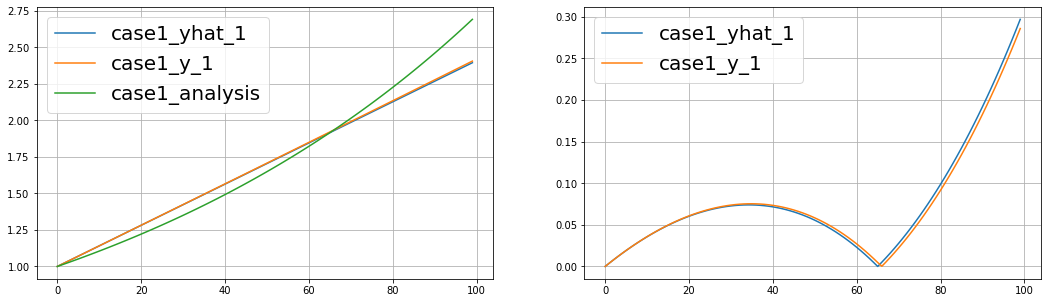

In [20]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

data_size = tf.size(x)
t1_1 = tf.concat([EC_W_1[0], EC_W_1[0]], 0)
t2_1 = tf.concat([EC_W_1[1], EC_W_1[1]], 1)
while tf.size(t1_1) != data_size*n*10:
    t1_1 = tf.concat([t1_1, EC_W_1[0]], 0)
    t2_1 = tf.concat([t2_1, EC_W_1[1]], 1)
t_W_1 = [t1_1, t2_1]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case1_yhat_1, label = 'case1_yhat_1')
ax.plot(case1_yhat_1 + neural_network(t_W_1, x)*x**(n+1), label = 'case1_y_1')
ax.plot(psy_analytic(x,1, case=case), label = 'case1_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case1_yhat_1 - psy_analytic(x,1, case=case)), label = 'case1_yhat_1')
ax2.plot(abs(case1_yhat_1 + neural_network(t_W_1, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case1_y_1')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


2차 + NN

1 + w1 * x + w2 * x ** 2 + NN * x ** 3

In [26]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 2
case = 1
case1_yhat_w_2, case1_low_loss_2 = yhat_w_loss(x, n, early_stop=1, case = case)
case1_yhat_2 = y(x, case1_yhat_w_2, n, case=case)
case1_yhatprime_2 = yprime(x, case1_yhat_w_2, n, bias = 0)
# add EC
EC_W_2, loss_2 = EC_W(x, case1_yhat_2, case1_yhatprime_2, n, min_loss=case1_low_loss_2, early_stop=1, case = case)

Start yhat
Epoch : 0, Loss_sum : 222.4786, w : [-0.45351   -1.5049704]
Epoch : 1000, Loss_sum : 105.8128, w : [ 0.5464843  -0.50495327]
Epoch : 2000, Loss_sum : 19.5149, w : [1.1687305 0.4298425]
Epoch : 3000, Loss_sum : 5.1901, w : [0.8822863  0.80214053]
early stop
low_loss_Epoch : 3427, low_Loss_sum : 5.1659, low_loss_w : <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.86918545, 0.81235504], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 3707.3311
Epoch : 1000, Loss_sum : 42.7043
Epoch : 2000, Loss_sum : 6.3644
early stop
low_loss_Epoch : 2045, low_Loss_sum : 4.4937, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 20) dtype=float32, numpy=
array([[-0.36000946,  0.09438725,  0.75595397,  1.8554916 ,  1.723178  ,
        -0.81848854,  0.3469874 ,  0.1316791 , -0.23559366, -0.09993646,
         0.33644095,  1.3801837 ,  1.2723866 , -0.31883502,  0.45305878,
         0.4950093 ,  0.94637394, -0.57815045, -1.802505  , -1.095035  ]],
      dtype=float32)>, <tf.Var

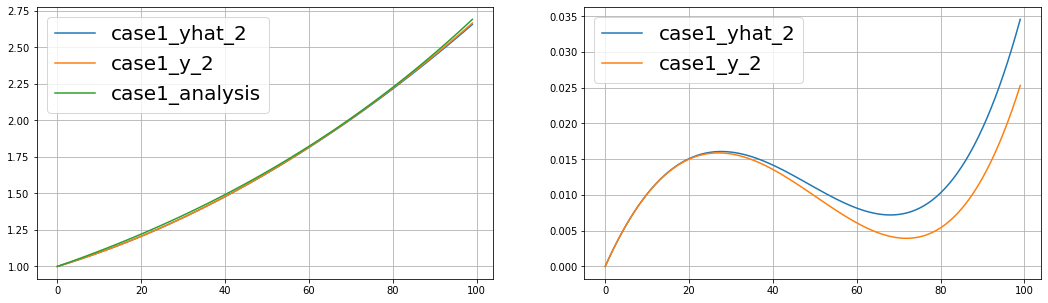

In [27]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

data_size = tf.size(x)
t1_2 = tf.concat([EC_W_2[0], EC_W_2[0]], 0)
t2_2 = tf.concat([EC_W_2[1], EC_W_2[1]], 1)
while tf.size(t1_2) != data_size*n*10:
    t1_2 = tf.concat([t1_2, EC_W_2[0]], 0)
    t2_2 = tf.concat([t2_2, EC_W_2[1]], 1)
t_W_2 = [t1_2, t2_2]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case1_yhat_2, label = 'case1_yhat_2')
ax.plot(case1_yhat_2 + neural_network(t_W_2, x)*x**(n+1), label = 'case1_y_2')
ax.plot(psy_analytic(x,1, case=case), label = 'case1_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case1_yhat_2 - psy_analytic(x,1, case=case)), label = 'case1_yhat_2')
ax2.plot(abs(case1_yhat_2 + neural_network(t_W_2, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case1_y_2')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

3차 + NN

1 + w1 * x + w2 * x ** 2 + w3 * x ** 3 + NN * x ** 4

In [55]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 3
case = 1
case1_yhat_w_3, case1_low_loss_3 = yhat_w_loss(x, n, early_stop=1, case = case)
case1_yhat_3 = y(x, case1_yhat_w_3, n, case=case)
case1_yhatprime_3 = yprime(x, case1_yhat_w_3, n, bias = 0)
# add EC
EC_W_3, loss_3 = EC_W(x, case1_yhat_3, case1_yhatprime_3, n, min_loss=case1_low_loss_3, early_stop=1, case = case)

Start yhat
Epoch : 0, Loss_sum : 74.0778, w : [0.47934029 0.21055101 1.470651  ]
Epoch : 1000, Loss_sum : 8.7540, w : [ 1.310777   -0.27597252  0.74157375]
Epoch : 2000, Loss_sum : 3.4996, w : [1.151614   0.13829894 0.4601815 ]
early stop
low_loss_Epoch : 2674, low_Loss_sum : 0.4342, low_loss_w : <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1.0160221, 0.4250119, 0.2777595], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 3959.3352
Epoch : 1000, Loss_sum : 59.6657
Epoch : 2000, Loss_sum : 12.0522
Epoch : 3000, Loss_sum : 4.2734
Epoch : 4000, Loss_sum : 1.7989
early stop
low_loss_Epoch : 4357, low_Loss_sum : 0.4124, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 30) dtype=float32, numpy=
array([[-8.1628941e-02, -1.5904087e+00,  6.3310400e-02,  7.4532700e-01,
        -7.9043794e-01, -8.2920474e-01,  2.5532559e-01, -3.7781253e-01,
         5.0537175e-01, -7.0428514e-01,  1.7345316e+00,  9.5945990e-01,
         2.5061746e+00,  4.6228909e-01, -1.0627911e+00,  1.4345

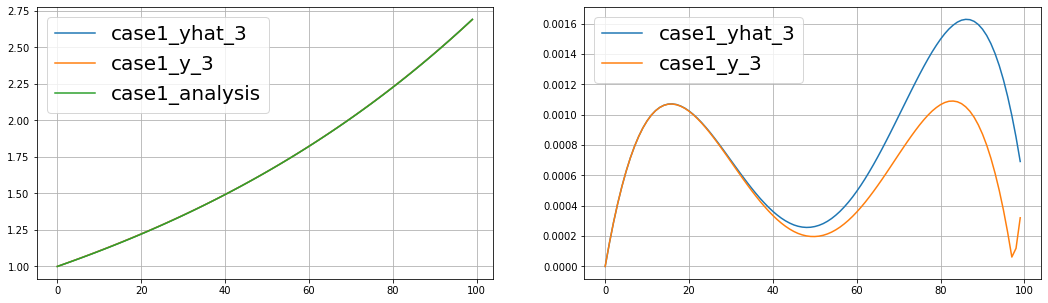

In [56]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

data_size = tf.size(x)
t1_3 = tf.concat([EC_W_3[0], EC_W_3[0]], 0)
t2_3 = tf.concat([EC_W_3[1], EC_W_3[1]], 1)
while tf.size(t1_3) != data_size*n*10:
    t1_3 = tf.concat([t1_3, EC_W_3[0]], 0)
    t2_3 = tf.concat([t2_3, EC_W_3[1]], 1)
t_W_3 = [t1_3, t2_3]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case1_yhat_3, label = 'case1_yhat_3')
ax.plot(case1_yhat_3 + neural_network(t_W_3, x)*x**(n+1), label = 'case1_y_3')
ax.plot(psy_analytic(x,1, case=case), label = 'case1_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case1_yhat_3 - psy_analytic(x,1, case=case)), label = 'case1_yhat_3')
ax2.plot(abs(case1_yhat_3 + neural_network(t_W_3, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case1_y_3')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [ ]:
'''
    yhat loss = yhatprime - f(x, yhat)
    
    psy = yhat + NN*x**(n+1)
    d_psy = yhatprime + (n+1)*NN*x**n + d_NN*x**(n+1)
    y loss = d_psy - f(x, psy)
'''

# psy_3 = yhat_3 + neural_network(t_W_3, x)*x**(n+1)
# d_psy_3 = yhatprime_3 + (n+1)*neural_network(t_W_3, x)*x**n + d_neural_network_dx(t_W_3, x)*x**(n+1)

# print('yhat loss : {:.4f}, y loss : {:.4f}'.format(tf.reduce_sum(tf.abs(yhat_3 - yhatprime_3)), tf.reduce_sum(tf.abs(d_psy_3 - f(x, psy_3)))))

'\n    yhat loss = yhatprime - f(x, yhat)\n    \n    psy = yhat + NN*x**(n+1)\n    d_psy = yhatprime + (n+1)*NN*x**n + d_NN*x**(n+1)\n    y loss = d_psy - f(x, psy)\n'

In [85]:
'''
    psy_analytic = exp(x)
    
    yhat error = yhat - psy_analytic

    psy = yhat + NN*x**(n+1)
    y error = psy - psy_analytic
'''

# print('yhat error : {:.4f}, y error : {:.4f}'.format(tf.reduce_sum(tf.abs(yhat_3 - psy_analytic(x, 1))), tf.reduce_sum(tf.abs(psy_3 - psy_analytic(x, 1)))))

'\n    psy_analytic = exp(x)\n    \n    yhat error = yhat - psy_analytic\n\n    psy = yhat + NN*x**(n+1)\n    y error = psy - psy_analytic\n'

Case 2

In [66]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
case = 2
W_size = 6
case2_yhat_w_1, case2_low_loss_1 = yhat_w_loss(x, n, early_stop=1, case = case)
case2_yhat_1 = y(x, case2_yhat_w_1, n, case=case)
case2_yhatprime_1 = yprime(x, case2_yhat_w_1, n, bias = 0)

# add EC
EC_W_1, loss_1 = EC_W(x, case2_yhat_1, case2_yhatprime_1, n, W_size = W_size, min_loss=case2_low_loss_1, early_stop=1, case = case)

Start yhat
Epoch : 0, Loss_sum : 191.1036, w : [-0.4092224]
Epoch : 1000, Loss_sum : 41.6045, w : [0.59077185]
early stop
low_loss_Epoch : 1766, low_Loss_sum : 12.3872, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.8762811], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 3330.4248
Epoch : 1000, Loss_sum : 32.7724
Epoch : 2000, Loss_sum : 26.2542
Epoch : 3000, Loss_sum : 15.3945
early stop
low_loss_Epoch : 3436, low_Loss_sum : 9.1216, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 6) dtype=float32, numpy=
array([[ 0.33990854, -1.6607552 , -1.2347854 , -1.2243373 , -0.8452569 ,
        -0.68997073]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(6, 1) dtype=float32, numpy=
array([[ 0.01044118],
       [-1.2246456 ],
       [-0.33559692],
       [ 0.28068766],
       [ 0.96120536],
       [ 1.8966414 ]], dtype=float32)>]


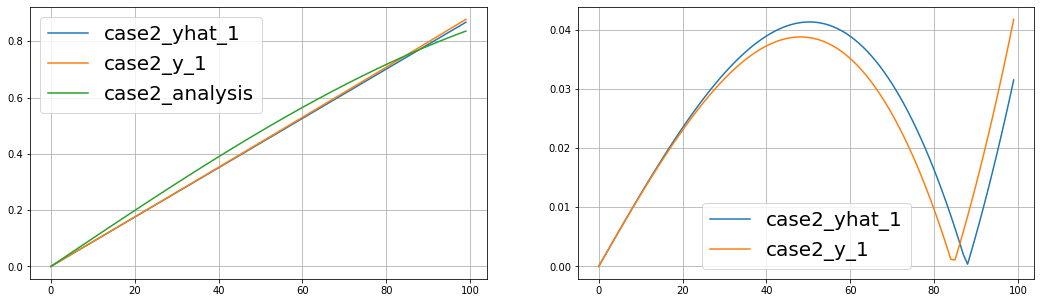

In [67]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

n = 1
data_size = tf.size(x)
t1_1 = tf.concat([EC_W_1[0], EC_W_1[0]], 0)
t2_1 = tf.concat([EC_W_1[1], EC_W_1[1]], 1)
while tf.size(t1_1) != data_size*n*W_size:
    t1_1 = tf.concat([t1_1, EC_W_1[0]], 0)
    t2_1 = tf.concat([t2_1, EC_W_1[1]], 1)
t_W_1 = [t1_1, t2_1]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case2_yhat_1, label = 'case2_yhat_1')
ax.plot(case2_yhat_1 + neural_network(t_W_1, x)*x**(n+1), label = 'case2_y_1')
ax.plot(psy_analytic(x,1, case=case), label = 'case2_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case2_yhat_1 - psy_analytic(x,1, case=case)), label = 'case2_yhat_1')
ax2.plot(abs(case2_yhat_1 + neural_network(t_W_1, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case2_y_1')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [24]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 2
case = 2
case2_yhat_w_2, case2_low_loss_2 = yhat_w_loss(x, n, early_stop=1, case = case)
case2_yhat_2 = y(x, case2_yhat_w_2, n, case = case)
case2_yhatprime_2 = yprime(x, case2_yhat_w_2, n, bias = 0)


Start yhat
Epoch : 0, Loss_sum : 270.6686, w : [-0.6150192 -0.3701476]


c:\Users\kyungryeol\Anaconda3\envs\ODE\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Epoch : 1000, Loss_sum : 40.6732, w : [0.28411376 0.46623132]
Epoch : 2000, Loss_sum : 24.1311, w : [0.6215179  0.20509331]
Epoch : 3000, Loss_sum : 2.8328, w : [ 1.0645994 -0.2171127]
early stop
low_loss_Epoch : 3324, low_Loss_sum : 2.7241, low_loss_w : <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 1.0826313, -0.2354415], dtype=float32)>


In [35]:
# add EC
EC_W_2, loss_2 = EC_W(x, case2_yhat_2, case2_yhatprime_2, n, min_loss=case2_low_loss_2, early_stop=3, case = case)

Start add EC
Epoch : 0, Loss_sum : 99.1307
early stop
low_loss_Epoch : 215, low_Loss_sum : 2.7158, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.33410314]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.00011833]], dtype=float32)>]


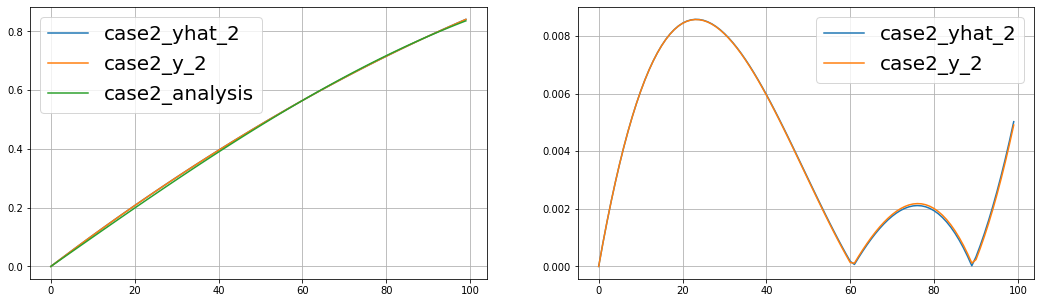

In [36]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

W_size = 1
n = 3
data_size = tf.size(x)
t1_2 = tf.concat([EC_W_2[0], EC_W_2[0]], 0)
t2_2 = tf.concat([EC_W_2[1], EC_W_2[1]], 1)
while tf.size(t1_2) != data_size*W_size:
    t1_2 = tf.concat([t1_2, EC_W_2[0]], 0)
    t2_2 = tf.concat([t2_2, EC_W_2[1]], 1)
t_W_2 = [t1_2, t2_2]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case2_yhat_2, label = 'case2_yhat_2')
ax.plot(case2_yhat_2 + neural_network(t_W_2, x)*x**(n+1), label = 'case2_y_2')
ax.plot(psy_analytic(x,1, case=case), label = 'case2_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case2_yhat_2 - psy_analytic(x,1, case=case)), label = 'case2_yhat_2')
ax2.plot(abs(case2_yhat_2 + neural_network(t_W_2, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case2_y_2')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [38]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 3
case = 2
case2_yhat_w_3, case2_low_loss_3 = yhat_w_loss(x, n, early_stop=1, case = case)
case2_yhat_3 = y(x, case2_yhat_w_3, n, case = case)
case2_yhatprime_3 = yprime(x, case2_yhat_w_3, n, bias = 0)

# add EC
EC_W_3, loss_3 = EC_W(x, case2_yhat_3, case2_yhatprime_3, n, min_loss=case2_low_loss_3, early_stop=1, case = case)

Start yhat
Epoch : 0, Loss_sum : 234.8076, w : [-1.334693    0.30285788  0.44490564]
Epoch : 1000, Loss_sum : 102.4803, w : [-0.62022215  0.70899266  0.5163551 ]
Epoch : 2000, Loss_sum : 42.0939, w : [ 0.132024    0.7821349  -0.19666828]
Epoch : 3000, Loss_sum : 8.5542, w : [ 0.6903572   0.69311255 -0.56301886]
Epoch : 4000, Loss_sum : 3.1739, w : [ 0.89125574  0.24450484 -0.3023904 ]
early stop
low_loss_Epoch : 4443, low_Loss_sum : 0.1243, low_loss_w : <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 1.0030464 , -0.01575625, -0.14612837], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 36.5288
early stop
low_loss_Epoch : 232, low_Loss_sum : 0.1207, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.24285516]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.00048092]], dtype=float32)>]


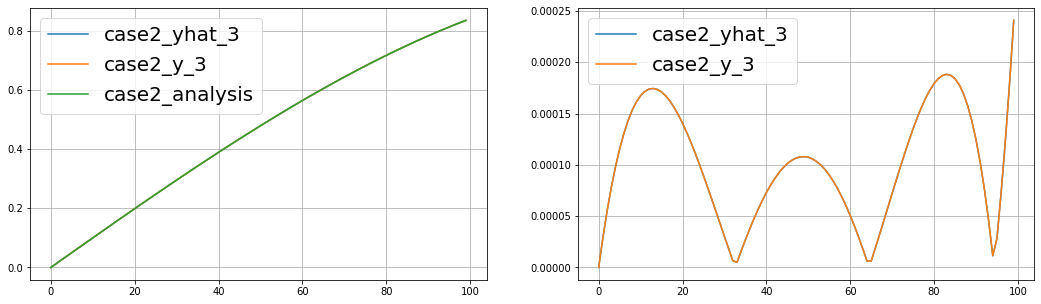

In [40]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

W_size = 1
n = 3
data_size = tf.size(x)
t1_3 = tf.concat([EC_W_3[0], EC_W_3[0]], 0)
t2_3 = tf.concat([EC_W_3[1], EC_W_3[1]], 1)
while tf.size(t1_3) != data_size*W_size:
    t1_3 = tf.concat([t1_3, EC_W_3[0]], 0)
    t2_3 = tf.concat([t2_3, EC_W_3[1]], 1)
t_W_3 = [t1_3, t2_3]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case2_yhat_3, label = 'case2_yhat_3')
ax.plot(case2_yhat_3 + neural_network(t_W_3, x)*x**(n+1), label = 'case2_y_3')
ax.plot(psy_analytic(x,1, case=case), label = 'case2_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case2_yhat_3 - psy_analytic(x,1, case=case)), label = 'case2_yhat_3')
ax2.plot(abs(case2_yhat_3 + neural_network(t_W_3, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case2_y_3')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


Case 3

In [38]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
W_size = 3
case = 3
case3_yhat_w_1, case3_low_loss_1 = yhat_w_loss(x, n, early_stop=1, case = case)
case3_yhat_1 = y(x, case3_yhat_w_1, n, case=case)
case3_yhatprime_1 = yprime(x, case3_yhat_w_1, n, bias = 0)

# add EC
EC_W_1, loss_1 = EC_W(x, case3_yhat_1, case3_yhatprime_1, W_size = W_size, n = n, min_loss=case3_low_loss_1, early_stop=1, case = case)

Start yhat
Epoch : 0, Loss_sum : 446.9735, w : [-1.4137859]
Epoch : 1000, Loss_sum : 199.4947, w : [-0.46438977]
Epoch : 2000, Loss_sum : 27.3496, w : [0.3905278]
early stop
low_loss_Epoch : 2704, low_Loss_sum : 19.3784, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.50622356], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 108.4548
early stop
low_loss_Epoch : 21, low_Loss_sum : 16.0950, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[-1.0687141, -1.2593387, -0.7943152]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.00891726],
       [ 1.4427574 ],
       [-2.2821958 ]], dtype=float32)>]


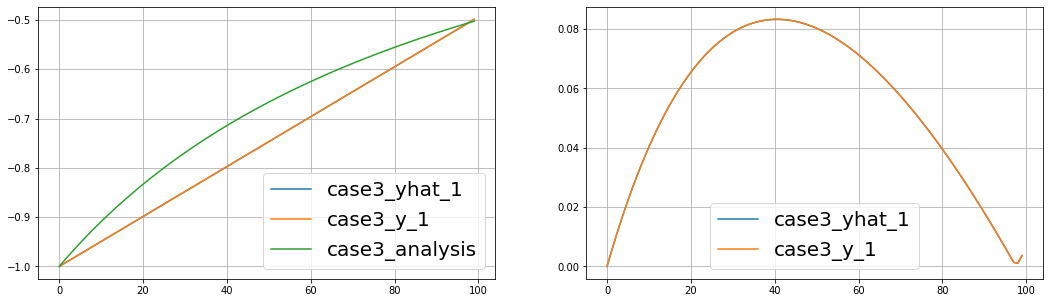

In [39]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

n = 1
data_size = tf.size(x)
t1_1 = tf.concat([EC_W_1[0], EC_W_1[0]], 0)
t2_1 = tf.concat([EC_W_1[1], EC_W_1[1]], 1)
while tf.size(t1_1) != data_size*n*W_size:
    t1_1 = tf.concat([t1_1, EC_W_1[0]], 0)
    t2_1 = tf.concat([t2_1, EC_W_1[1]], 1)
t_W_1 = [t1_1, t2_1]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case3_yhat_1, label = 'case3_yhat_1')
ax.plot(case3_yhat_1 + neural_network(t_W_1, x)*x**(n+1), label = 'case3_y_1')
ax.plot(psy_analytic(x,1, case=case), label = 'case3_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case3_yhat_1 - psy_analytic(x,1, case=case)), label = 'case3_yhat_1')
ax2.plot(abs(case3_yhat_1 + neural_network(t_W_1, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case3_y_1')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [14]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 2
case = 3
case3_yhat_w_2, case3_low_loss_2 = yhat_w_loss(x, n, early_stop=1, case = case)
case3_yhat_2 = y(x, case3_yhat_w_2, n, case=case)
case3_yhatprime_2 = yprime(x, case3_yhat_w_2, n, bias = 0)

# add EC
EC_W_2, loss_2 = EC_W(x, case3_yhat_2, case3_yhatprime_2, n, min_loss=case3_low_loss_2, early_stop=1, case = case)

Start yhat
Epoch : 0, Loss_sum : 47.6222, w : [0.07849121 0.49155602]
early stop
low_loss_Epoch : 998, low_Loss_sum : 4.4676, low_loss_w : <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.8047227, -0.3127739], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 255.6475
early stop
low_loss_Epoch : 210, low_Loss_sum : 4.3977, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[-0.28204125, -0.13943636]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.5177022],
       [ 1.045375 ]], dtype=float32)>]


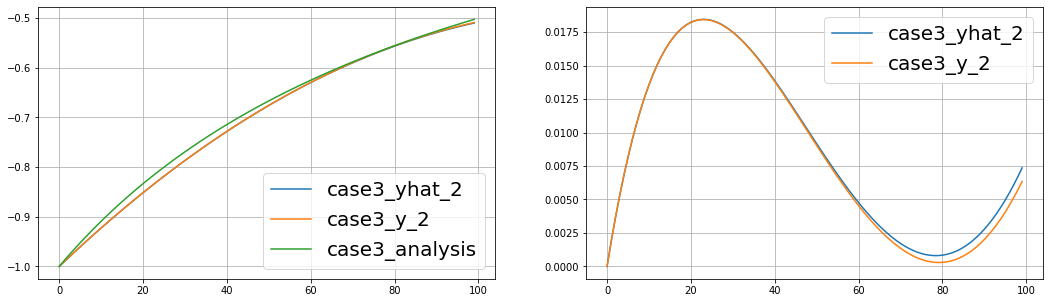

In [15]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

n = 2
W_size = 1
data_size = tf.size(x)
t1_2 = tf.concat([EC_W_2[0], EC_W_2[0]], 0)
t2_2 = tf.concat([EC_W_2[1], EC_W_2[1]], 1)
while tf.size(t1_2) != data_size*n*W_size:
    t1_2 = tf.concat([t1_2, EC_W_2[0]], 0)
    t2_2 = tf.concat([t2_2, EC_W_2[1]], 1)
t_W_2 = [t1_2, t2_2]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case3_yhat_2, label = 'case3_yhat_2')
ax.plot(case3_yhat_2 + neural_network(t_W_2, x)*x**(n+1), label = 'case3_y_2')
ax.plot(psy_analytic(x,1, case=case), label = 'case3_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case3_yhat_2 - psy_analytic(x,1, case=case)), label = 'case3_yhat_2')
ax2.plot(abs(case3_yhat_2 + neural_network(t_W_2, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case3_y_2')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [7]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 3
case = 3
case3_yhat_w_3, case3_low_loss_3 = yhat_w_loss(x, n, early_stop=1, case = case)
case3_yhat_3 = y(x, case3_yhat_w_3, n, case=case)
case3_yhatprime_3 = yprime(x, case3_yhat_w_3, n, bias = 0)

# add EC
EC_W_3, loss_3 = EC_W(x, case3_yhat_3, case3_yhatprime_3, n, min_loss=case3_low_loss_3, early_stop=1, case = case)

Start yhat
Epoch : 0, Loss_sum : 359.5771, w : [-0.30359772 -0.5961075  -0.44475308]


c:\Users\kyungryeol\Anaconda3\envs\ODE\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Epoch : 1000, Loss_sum : 25.7666, w : [ 0.40097326 -0.00412412  0.05479972]
Epoch : 2000, Loss_sum : 7.5681, w : [ 0.67879343 -0.05870607 -0.13497113]
Epoch : 3000, Loss_sum : 5.5468, w : [ 0.75169325 -0.21846879 -0.04397379]
Epoch : 4000, Loss_sum : 2.2406, w : [ 0.86071116 -0.48362646  0.11841821]
early stop
low_loss_Epoch : 4708, low_Loss_sum : 1.0348, low_loss_w : <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.93032855, -0.63178277,  0.20116213], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 1955.3000
Epoch : 1000, Loss_sum : 1.7097
Epoch : 2000, Loss_sum : 1.3012
Epoch : 3000, Loss_sum : 1.1805
Epoch : 4000, Loss_sum : 1.2030
Epoch : 5000, Loss_sum : 1.2555
Epoch : 6000, Loss_sum : 1.0940
Epoch : 7000, Loss_sum : 1.1269
early stop
low_loss_Epoch : 7855, low_Loss_sum : 1.0307, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 30) dtype=float32, numpy=
array([[-0.04624195, -0.07003047,  0.3287433 ,  0.2532453 , -0.26883668,
         0.49864137, -1.5644692 ,

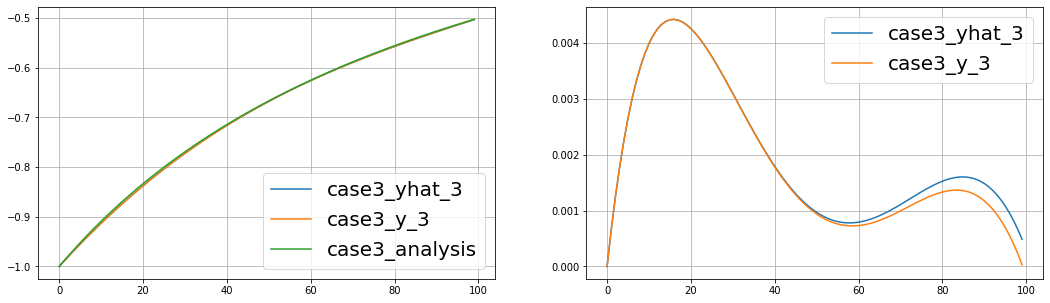

In [8]:
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

n = 3
W_size = 10
data_size = tf.size(x)
t1_3 = tf.concat([EC_W_3[0], EC_W_3[0]], 0)
t2_3 = tf.concat([EC_W_3[1], EC_W_3[1]], 1)
while tf.size(t1_3) != data_size*n*W_size:
    t1_3 = tf.concat([t1_3, EC_W_3[0]], 0)
    t2_3 = tf.concat([t2_3, EC_W_3[1]], 1)
t_W_3 = [t1_3, t2_3]

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(case3_yhat_3, label = 'case3_yhat_3')
ax.plot(case3_yhat_3 + neural_network(t_W_3, x)*x**(n+1), label = 'case3_y_3')
ax.plot(psy_analytic(x,1, case=case), label = 'case3_analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(case3_yhat_3 - psy_analytic(x,1, case=case)), label = 'case3_yhat_3')
ax2.plot(abs(case3_yhat_3 + neural_network(t_W_3, x)*x**(n+1) - psy_analytic(x,1, case=case)), label = 'case3_y_3')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()
